# Load pre-analyzed datasets to quickly compare multi-month temperature changes

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import xarray as xr
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cmocean.cm as cmo
import xroms

import calendar
import datetime
from scipy.stats import geom
from glob import glob
import os

from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
from shapely.geometry.polygon import LinearRing

In [2]:
sroot = '/qfs/people/hins978/Notebooks/Kestrel_Notebooks/Turbine_outputs_SoloROMS/'
croot = '/qfs/people/hins978/Notebooks/Kestrel_Notebooks/Turbine_outputs_CoupledCOAWST/'

In [4]:
yvec = [2021, 2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022]
mvec = [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]

In [7]:
# Load in model output data

sroot = 'Turbine_outputs_SoloROMS/'
croot = 'Turbine_outputs_CoupledCOAWST/'

solo_dss = []
solo_dfs = []
cpd_dss = []
cpd_dfs = []
sshs = []
salts = []
solo_upwls = []
cpd_upwls = []

for j in range(len(mvec)):
    calmon = calendar.month_abbr[mvec[j]]
    dstr = str(yvec[j]) + calmon
    sds = xr.open_dataset(sroot + dstr + '_temp_SpatialAvg.nc')
    sdf = pd.read_csv(sroot + dstr + '_temp_TimeSeries.csv')
    cds = xr.open_dataset(croot + dstr + '_temp_SpatialAvg.nc')
    cdf = pd.read_csv(croot + dstr + '_temp_TimeSeries.csv')
    ssh = xr.open_dataset(croot + dstr + '_ssh_SpatialAvg.nc')
    salt = xr.open_dataset(croot + dstr + '_salt_SpatialAvg.nc')
    supwlng = xr.open_dataset(sroot + dstr + '_upwellingSlices_diff.nc')
    cupwlng = xr.open_dataset(croot + dstr + '_upwellingSlices_diff.nc')
    # Cut down dfs to 30 day lengths
    if len(sdf)>241:
        sdf = sdf[0:241]
    if len(cdf)>241:
        cdf = cdf[0:241]
    solo_dss.append(sds)
    solo_dfs.append(sdf)
    cpd_dss.append(cds)
    cpd_dfs.append(cdf)
    sshs.append(ssh)
    salts.append(salt)
    solo_upwls.append(supwlng)
    cpd_upwls.append(cupwlng)

## Calculate Annual SST changes

In [11]:
# grab lon/lat to plot larger averaging area

lonc0 = solo_dss[0].temp.lon_rho[ 75,200].values
lonc1 = solo_dss[0].temp.lon_rho[325,200].values
lonc2 = solo_dss[0].temp.lon_rho[325,400].values
lonc3 = solo_dss[0].temp.lon_rho[ 75,400].values

latc0 = solo_dss[0].temp.lat_rho[ 75,200].values
latc1 = solo_dss[0].temp.lat_rho[325,200].values
latc2 = solo_dss[0].temp.lat_rho[325,400].values
latc3 = solo_dss[0].temp.lat_rho[ 75,400].values

alonring = np.hstack((lonc0, lonc1, lonc2, lonc3))
alatring = np.hstack((latc0, latc1, latc2, latc3))

aring = LinearRing(list(zip(alonring, alatring)))

# grab lon/lat to plot extent of turbine array

lonc0 = dss[0].lon_rho[210,285].values
lonc1 = dss[0].lon_rho[229,285].values
lonc2 = dss[0].lon_rho[229,311].values
lonc3 = dss[0].lon_rho[210,311].values

latc0 = dss[0].lat_rho[210,285].values
latc1 = dss[0].lat_rho[229,285].values
latc2 = dss[0].lat_rho[229,311].values
latc3 = dss[0].lat_rho[210,311].values

lonring = np.hstack((lonc0, lonc1, lonc2, lonc3))
latring = np.hstack((latc0, latc1, latc2, latc3))

ring = LinearRing(list(zip(lonring, latring)))

In [ ]:
solo_lee_avg = []
cpd_lee_avg = []

for ds in solo_dss:
    x = ds.temp
    solo_lee_avg.append(xr.DataArray(x,dims=('eta_rho','xi_rho')))

for ds in cpd_dss:
    x = ds.temp
    cpd_lee_avg.append(xr.DataArray(x,dims=('eta_rho','xi_rho')))

In [ ]:
coupled_avg = []
mon_avg = []
mon_std = []
for ds in dss:
    x = ds.temp
    coupled_avg.append(xr.DataArray(x,dims=('eta_rho','xi_rho')))
    mon_avg.append(ds.temp.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).mean().compute().values)
    mon_std.append(ds.temp.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).std().compute().values)
    
ann_concat = xr.concat(coupled_avg, dim='time')
tsubset = ann_concat.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).mean(dim=['time']).compute()


Text(0.5, 0, '$\\Delta$ Surface Temperature, $^\\circ$C')

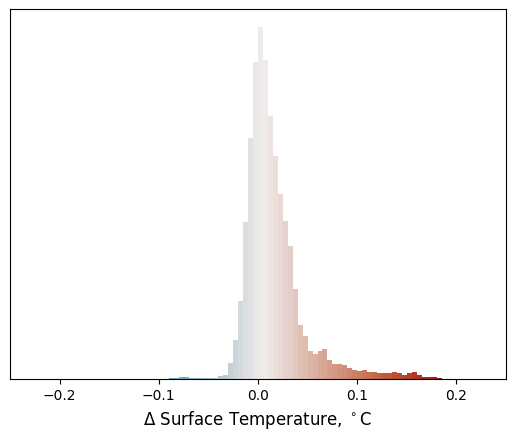

In [ ]:
# Histogram colorbar

bar_cols = cmo.balance(np.arange(0,1,1/101))
bins = np.linspace(-0.25, 0.25, 101)
n, bins2, patches = plt.hist(np.ravel(tsubset.values), bins, density=True, facecolor=bar_cols,
                            orientation='vertical')# histtype='bar')
for i in range(len(patches)):

    patches[i].set_facecolor(bar_cols[i])
plt.xlim([-0.25, 0.25])
plt.yticks([], [])
plt.xlabel('$\Delta$ Surface Temperature, $^\circ$C', fontsize=12)


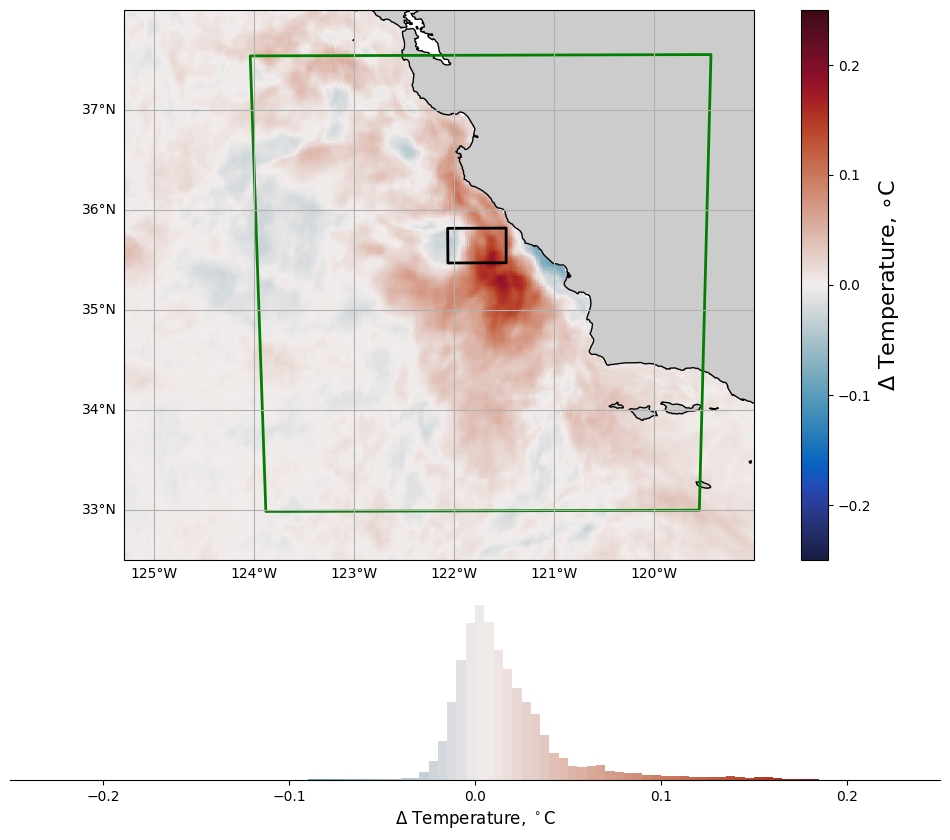

In [ ]:
# Figure 5

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.1)

#-------------------------------------------------------------------------------------#
# Map plot
#-------------------------------------------------------------------------------------#
ax = plt.subplot(gs[0], projection=proj)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)
pc = ann_concat.mean(dim='time').plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.25, vmax=0.25,
                                add_colorbar=False)
cb = fig.colorbar(pc)
cb.set_label('$\Delta$ Temperature, $\circ$C', fontsize=16)
cb.ax.tick_params(labelsize=10)
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
ax.add_geometries([aring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-125.3, -119, 32.5, 38], crs=ccrs.PlateCarree())

plt.title('', fontsize=24)

#-------------------------------------------------------------------------------------#
# Histogram colorbar
#-------------------------------------------------------------------------------------#
ax = plt.subplot(gs[1])

bins = np.linspace(-0.25, 0.25, 101)
n, bins2, patches = plt.hist(np.ravel(tsubset.values), bins, density=True, facecolor=bar_cols,
                            orientation='vertical')# histtype='bar')
for i in range(len(patches)):
    patches[i].set_facecolor(bar_cols[i])
ax.set_xlim([-0.25, 0.25])
ax.set_yticks([], [])
ax.set_xlabel('$\Delta$ Temperature, $^\circ$C', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('Figure_5.png', format='png', dpi=300, bbox_inches='tight')

In [ ]:
# Average annual change in SST reported in manuscript

print(cpd_dss[1].temp.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).mean().values.item())
print(cpd_dss[1].temp.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).std().values.item())

0.023094460368156433
0.0503045953810215


### Figure 6 - Monthly Averaged SST Changes

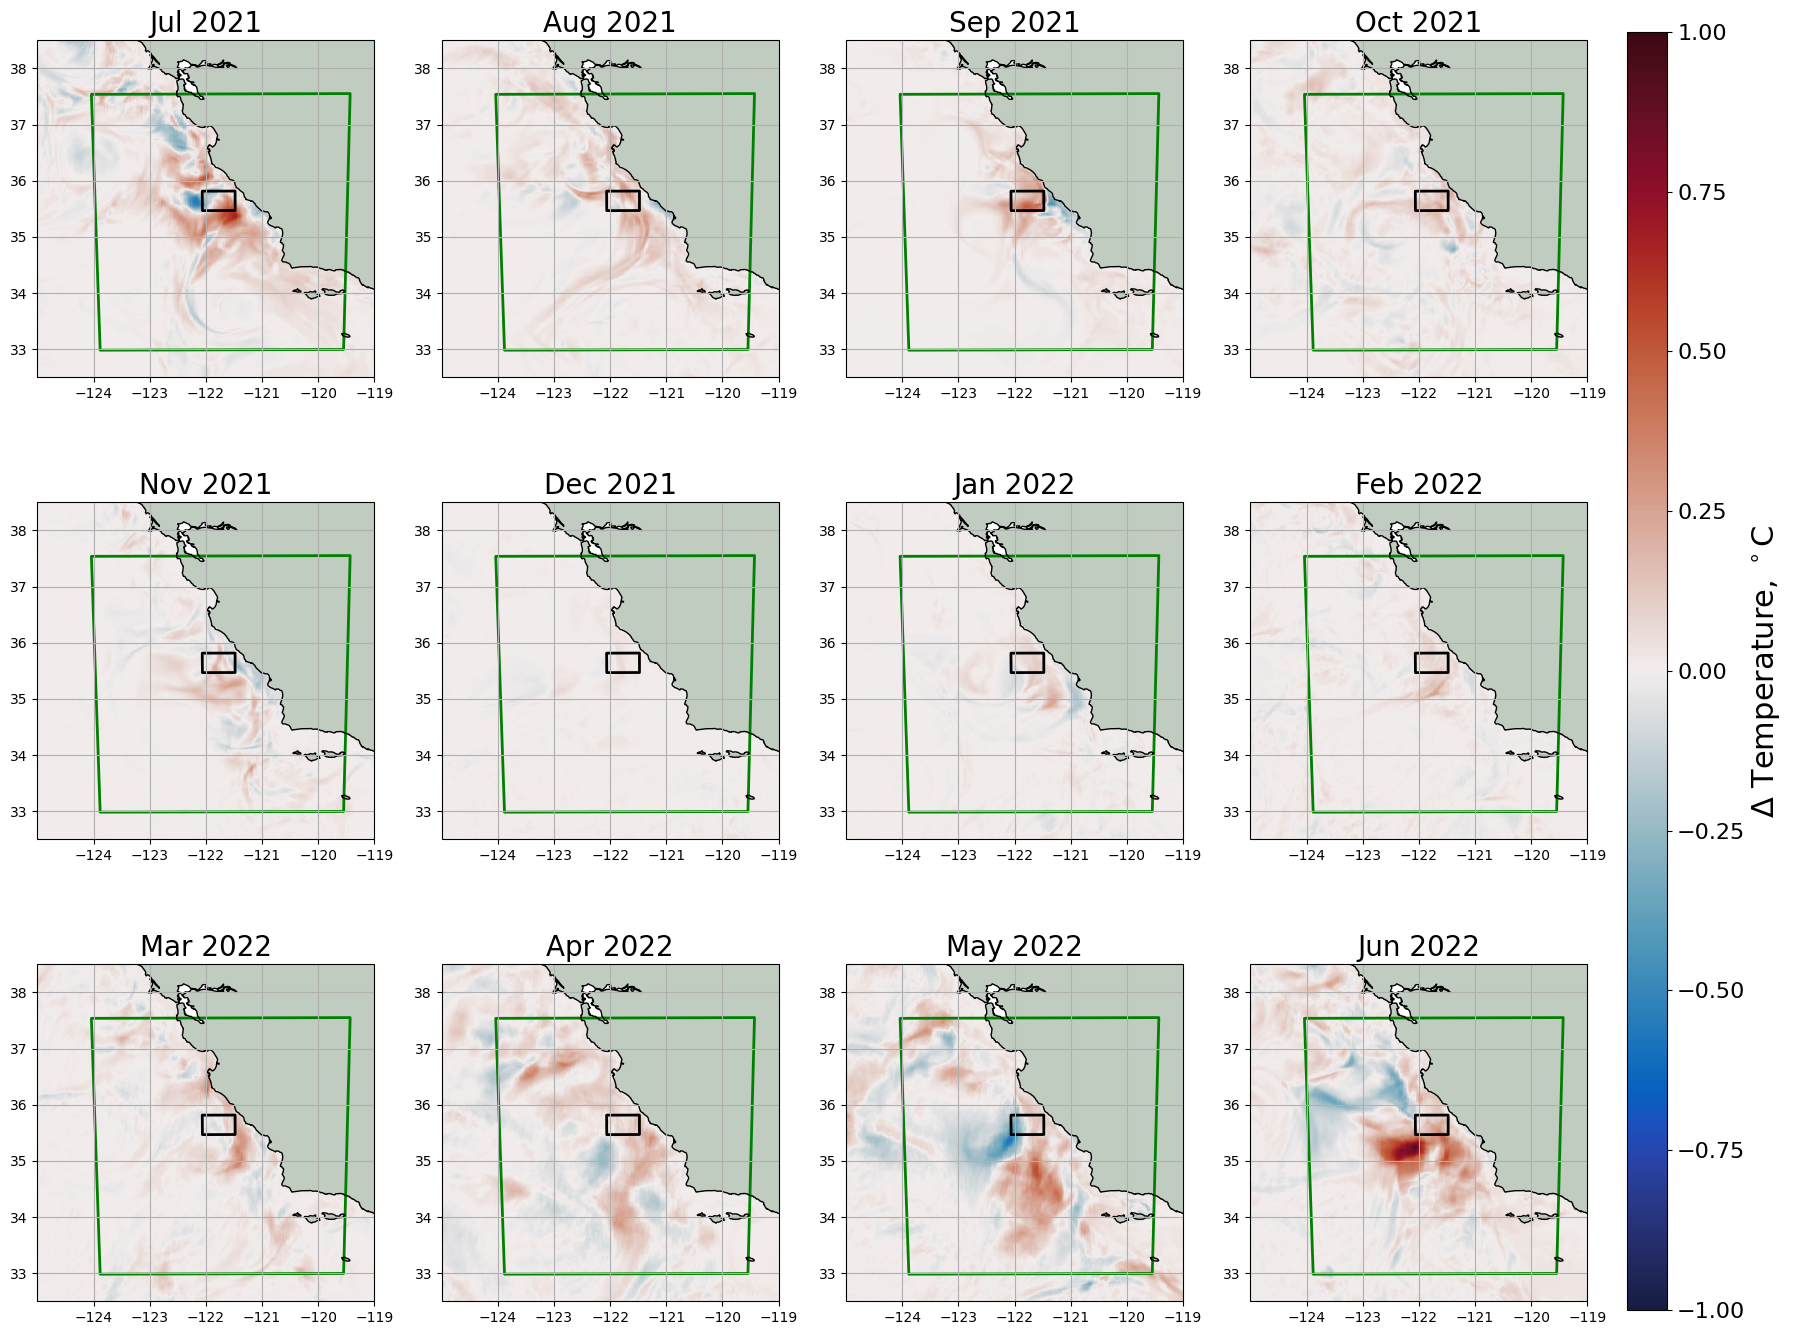

In [ ]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], hspace=0)

for i in range(12):
    ax = plt.subplot(gs[i], projection=proj)
    if (i % 3) < 2:
        pc = cpd_dss[i].temp.plot(x='lon_rho', y='lat_rho', cmap=cmo.balance, ax=ax,
                         transform=ccrs.PlateCarree(), vmin=-1, vmax=1, add_colorbar=False)
    else: # Right edge of grid
        pc = cpd_dss[i].temp.plot(x='lon_rho', y='lat_rho', cmap=cmo.balance, ax=ax,
                         transform=ccrs.PlateCarree(), vmin=-1, vmax=1, add_colorbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(calendar.month_abbr[mvec[i]] + ' ' + str(yvec[i]), fontsize=20)
    
    # Add turbine array location
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
    ax.add_geometries([aring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2)

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor=(0.75, 0.8, 0.75))
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    # adding grid lines
    ax.set_yticks([33, 34, 35, 36, 37, 38])
    ax.set_xticks([-124, -123, -122, -121, -120, -119])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_xlim([-125, -119])
    ax.set_ylim([32.5, 38.5])
    

cax = fig.add_axes([0.92, 0.14, 0.02, 0.71])

cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=22)
cbar.ax.tick_params(labelsize=16)

fig.savefig('Figure_6.png', format='png', dpi=300, bbox_inches='tight')

## Plot all Monthly Time Series - Figure 7

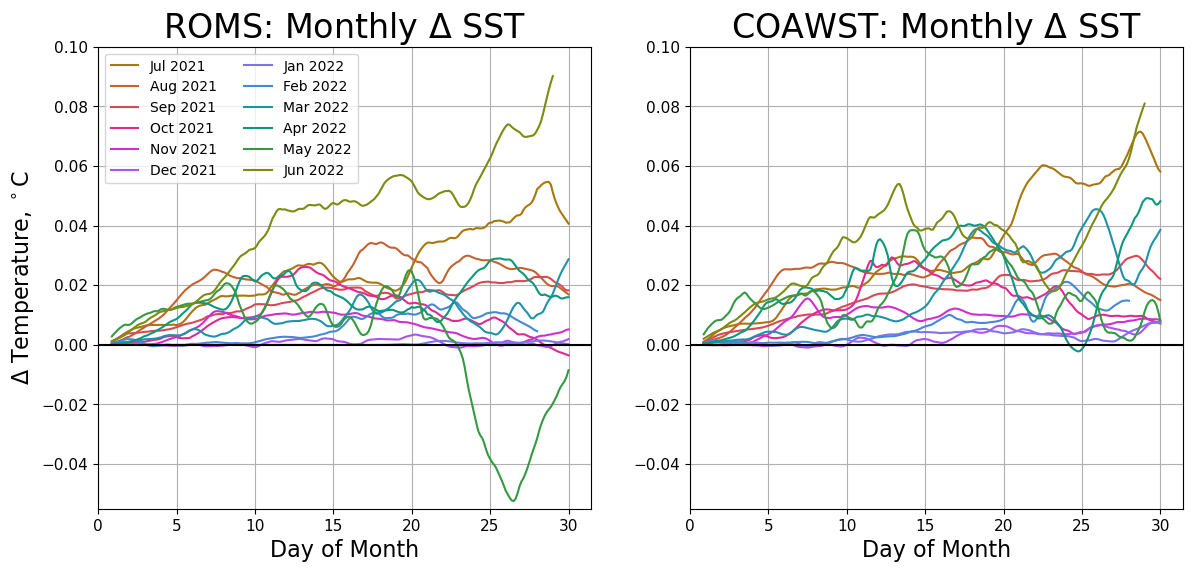

In [12]:
# Plot all monthly time series

phase_grab = cmo.phase(np.arange(0,1,1/12)) # colormap for multiple months

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121)

k=0
for df in solo_dfs:
    mstr = calendar.month_abbr[np.unique(pd.to_datetime(df.Date).dt.month)[0].item()]
    ystr = str(np.unique(pd.to_datetime(df.Date).dt.year)[0].item())
    xgrab = pd.to_datetime(df.Date)
    xplot = (xgrab - xgrab[0]) / np.timedelta64(1,'D')
    ax.plot(xplot, df.Surface_Temp.rolling(8).mean(), label=mstr + ' ' + ystr, color=phase_grab[k])
    k+=1

ax.grid()
ax.legend(ncol=2)
ax.set_ylim([-0.055, 0.1])
ax.set_xlim([0, None])

ax.set_title('ROMS: Monthly $\Delta$ SST', fontsize=24)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)
ax.set_xlabel('Day of Month', fontsize=16)
plt.axhline(y=0, color='k', linestyle='-')

# Coupled COAWST results
ax = fig.add_subplot(122)

k=0
for df in cpd_dfs:
    mstr = calendar.month_abbr[np.unique(pd.to_datetime(df.Date).dt.month)[0].item()]
    ystr = str(np.unique(pd.to_datetime(df.Date).dt.year)[0].item())
    xgrab = pd.to_datetime(df.Date)
    xplot = (xgrab - xgrab[0]) / np.timedelta64(1,'D')
    ax.plot(xplot, df.Surface_Temp.rolling(8).mean(), label=mstr + ' ' + ystr, color=phase_grab[k])
    k+=1

ax.grid()
ax.set_ylim([-0.055, 0.1])
ax.set_xlim([0, None])
ax.set_title('COAWST: Monthly $\Delta$ SST', fontsize=24)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_xlabel('Day of Month', fontsize=16)
plt.axhline(y=0, color='k', linestyle='-')


In [ ]:
# Calculate annual changes
ssurf_tss = []
csurf_tss = []

for df in solo_dfs:
    ssurf_tss.append(df.Surface_Temp.values[0:225])
for df in cpd_dfs:
    csurf_tss.append(df.Surface_Temp.values[0:225])

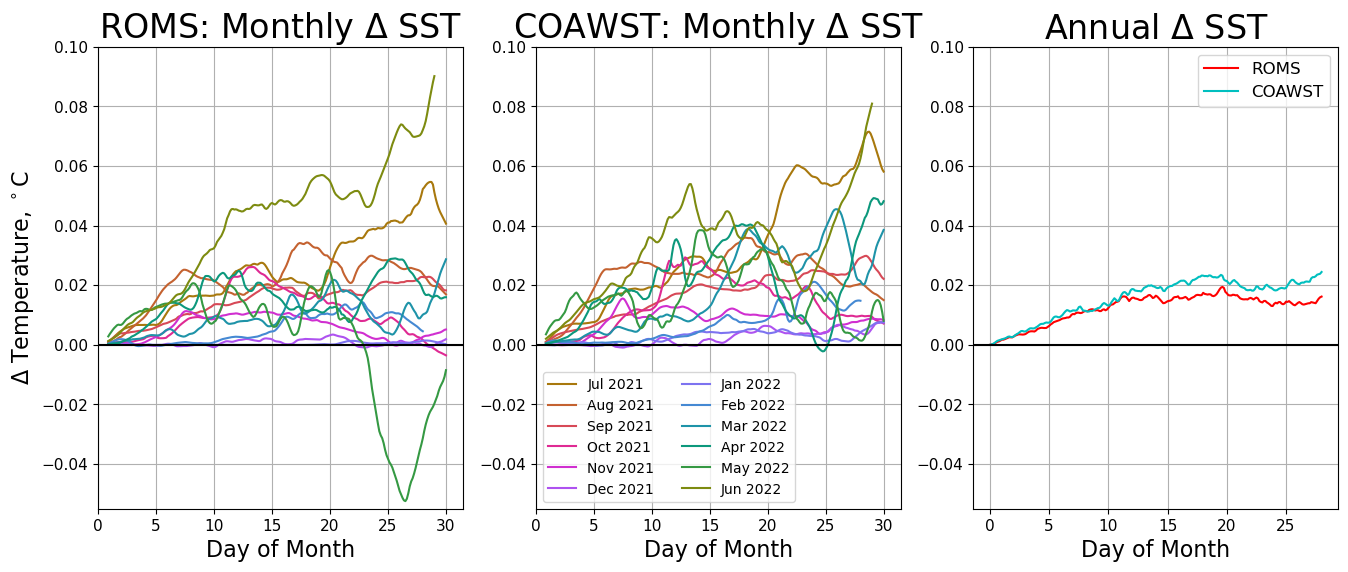

In [15]:
# Plot monthly and annual time series together

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)

k=0
for df in solo_dfs:
    mstr = calendar.month_abbr[np.unique(pd.to_datetime(df.Date).dt.month)[0].item()]
    ystr = str(np.unique(pd.to_datetime(df.Date).dt.year)[0].item())
    xgrab = pd.to_datetime(df.Date)
    xplot = (xgrab - xgrab[0]) / np.timedelta64(1,'D')
    ax.plot(xplot, df.Surface_Temp.rolling(8).mean(), label=mstr + ' ' + ystr, color=phase_grab[k])
    k+=1

ax.grid()
ax.set_ylim([-0.055, 0.1])
ax.set_xlim([0, None])

ax.set_title('ROMS: Monthly $\Delta$ SST', fontsize=24)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)
ax.set_xlabel('Day of Month', fontsize=16)
plt.axhline(y=0, color='k', linestyle='-')

# Coupled COAWST results
ax = fig.add_subplot(132)

k=0
for df in cpd_dfs:
    mstr = calendar.month_abbr[np.unique(pd.to_datetime(df.Date).dt.month)[0].item()]
    ystr = str(np.unique(pd.to_datetime(df.Date).dt.year)[0].item())
    xgrab = pd.to_datetime(df.Date)
    xplot = (xgrab - xgrab[0]) / np.timedelta64(1,'D')
    ax.plot(xplot, df.Surface_Temp.rolling(8).mean(), label=mstr + ' ' + ystr, color=phase_grab[k])
    k+=1

ax.grid()
ax.legend(ncol=2)
ax.set_ylim([-0.055, 0.1])
ax.set_xlim([0, None])
ax.set_title('COAWST: Monthly $\Delta$ SST', fontsize=24)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_xlabel('Day of Month', fontsize=16)
plt.axhline(y=0, color='k', linestyle='-')

# Annual Results
ax = fig.add_subplot(133)

solo_surf_arr = np.array([ssurf_tss])
cpd_surf_arr = np.array([csurf_tss])
ax.plot(xplot[0:225], np.ravel(np.mean(solo_surf_arr, axis=1)), label='ROMS', color='r')
ax.plot(xplot[0:225], np.ravel(np.mean(cpd_surf_arr, axis=1)), label='COAWST', color='c')

ax.grid()
ax.legend(fontsize=12)
ax.set_title('Annual $\Delta$ SST', fontsize=24)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_xlabel('Day of Month', fontsize=16)
ax.set_ylim([-0.055, 0.1])
ax.axhline(y=0, color='k', linestyle='-')


savepath = '/qfs/people/hins978/Notebooks/Kestrel_Notebooks/'
fig.savefig('Figure_7.png', format='png', dpi=300, bbox_inches='tight')

## Plot Annual SSH and Salinity changes - Figure 8

In [32]:
ssh_avg = []
for ds in sshs:
    x = ds.zeta
    ssh_avg.append(xr.DataArray(x,dims=('eta_rho','xi_rho')))

ssh_concat = xr.concat(ssh_avg, dim='time')

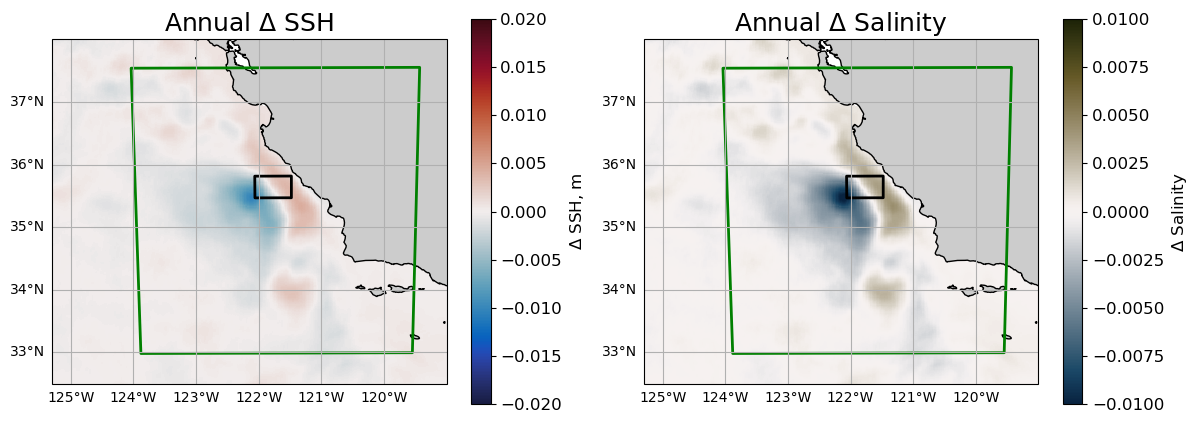

In [37]:
fig = plt.figure(figsize=(14, 5))

gs = GridSpec(1, 2, width_ratios=[1, 1])
proj = ccrs.PlateCarree()

#----------------------------------------------------------------------#
# Delta SSH

ax = fig.add_subplot(gs[0], projection=proj)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = ssh_concat.mean(dim='time').plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.02, vmax=0.02, add_colorbar=False)

cb = fig.colorbar(pc)
cb.set_label('$\Delta$ SSH, m', fontsize=12)
cb.ax.tick_params(labelsize=12)

ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
ax.add_geometries([aring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-125.3, -119, 32.5, 38], crs=ccrs.PlateCarree())

plt.title('Annual $\Delta$ SSH', fontsize=18)

#----------------------------------------------------------------------#

# Delta Salinity

ax = fig.add_subplot(gs[1], projection=proj)


coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = salt_concat.mean(dim='time').plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.diff, vmin=-0.01, vmax=0.01, add_colorbar=False)

cb = fig.colorbar(pc)
cb.set_label('$\Delta$ Salinity', fontsize=12)
cb.ax.tick_params(labelsize=12)

ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
ax.add_geometries([aring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-125.3, -119, 32.5, 38], crs=ccrs.PlateCarree())

plt.title('Annual $\Delta$ Salinity', fontsize=18)

fig.savefig('Figure_8.png', format='png', dpi=300, bbox_inches='tight')

## Plot Upwelling Changes

In [9]:
udist_lgd = ['2 km',   '5 km', '10 km',
             '15 km', '20 km', '25 km',
             '30 km', '40 km', '50 km',
             '75 km', '100 km']
udist_km = [2,5,10,15,20,25,30,40,50,75,100]

turb_loc = udist_km[8]+5


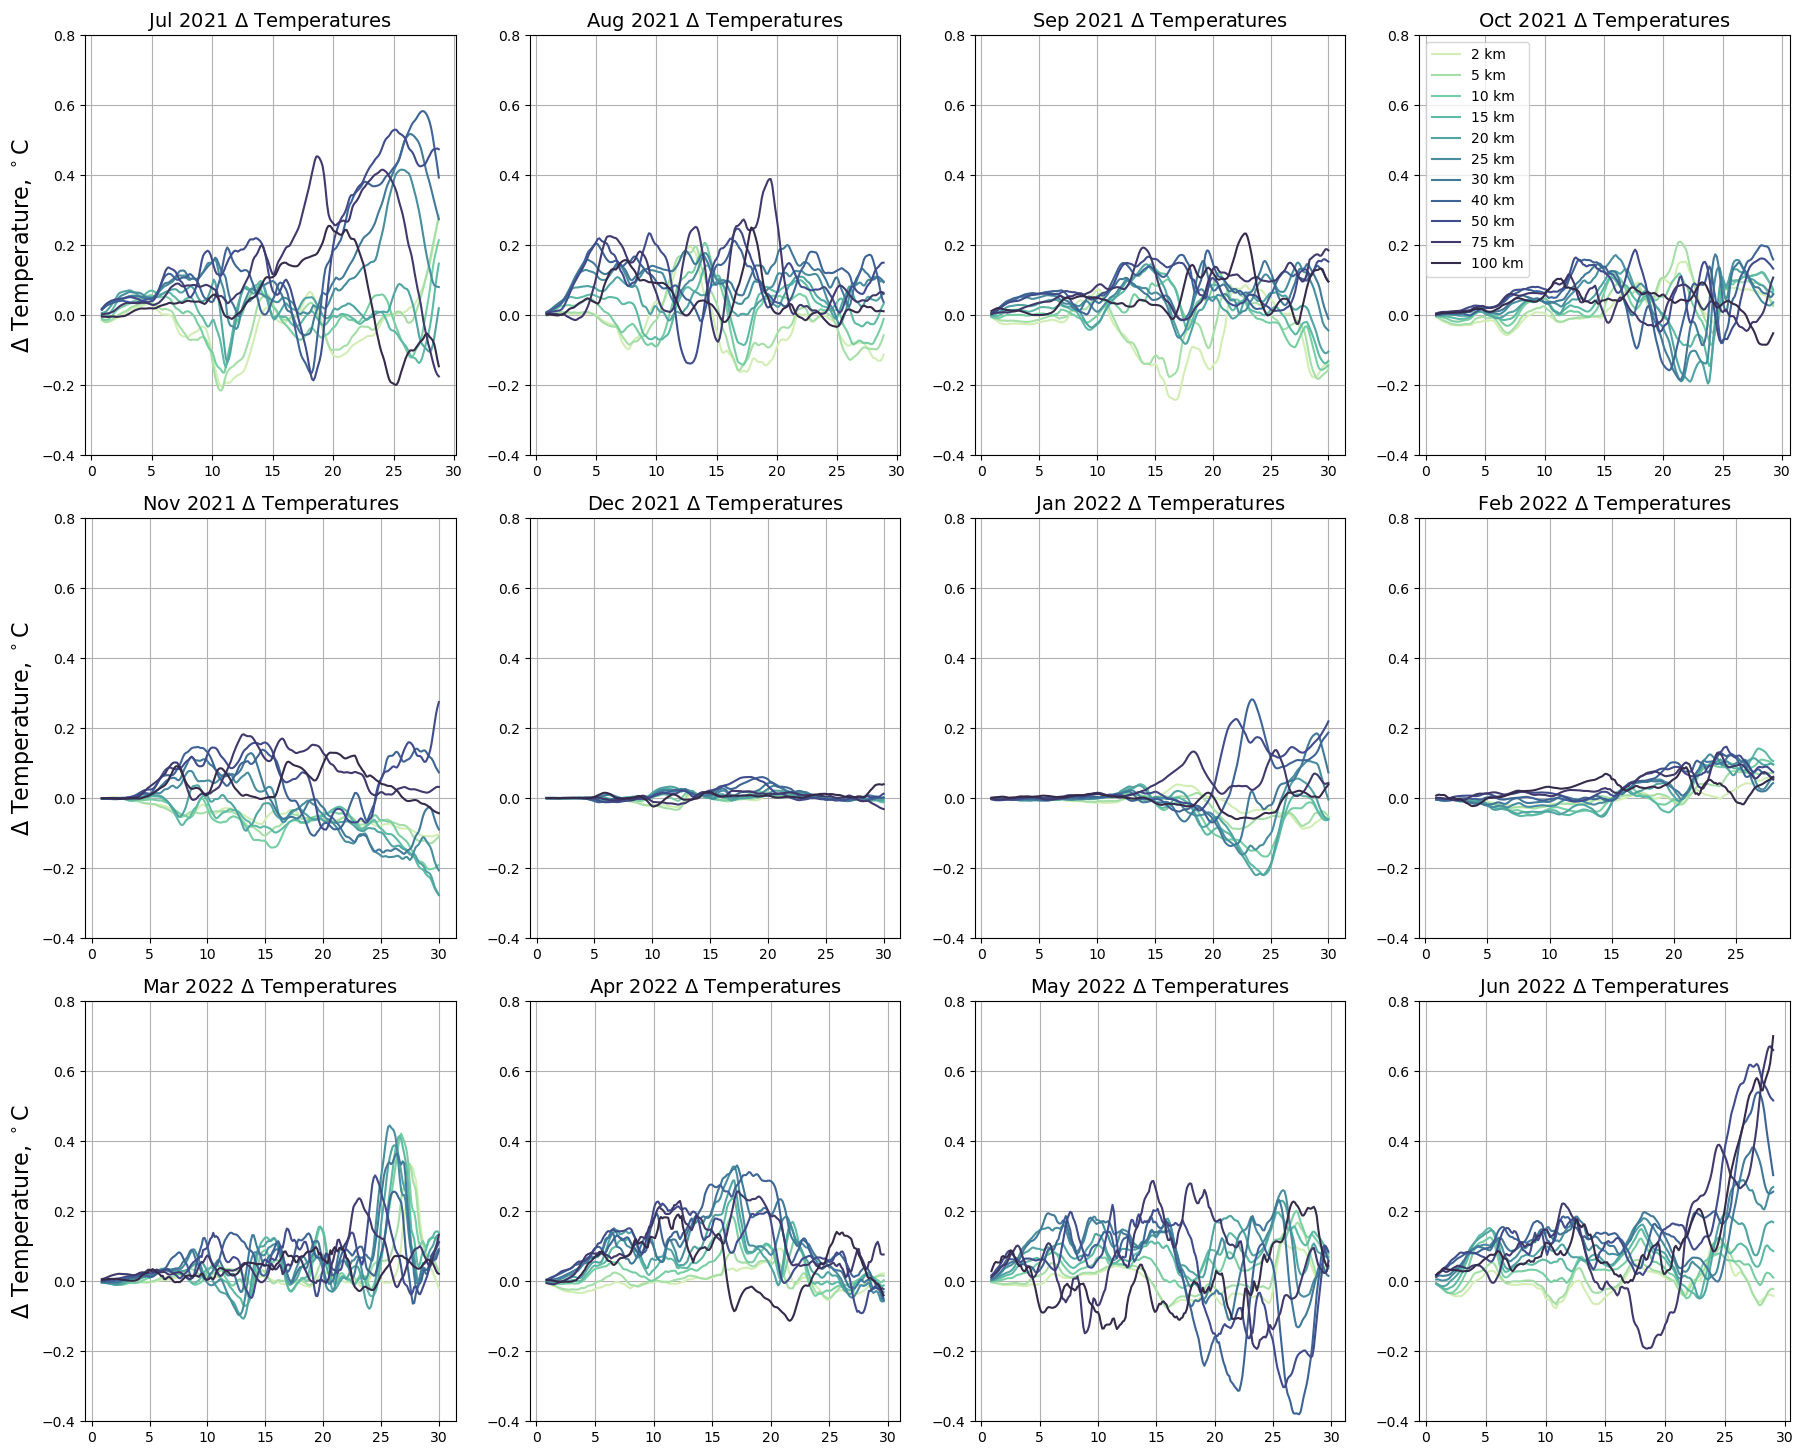

In [20]:
# Plot all COAWST monthly time series of SST changes at different distances from shore

fig = plt.figure(figsize=(22, 18))
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], hspace=0.15)

for i in range(12):
    udiff = cpd_upwls[i]
    ax = plt.subplot(gs[i])
    for k in range(len(udiff.temp)):
        xgrab = pd.to_datetime(udiff.ocean_time)
        xplot = (xgrab - xgrab[0]) / np.timedelta64(1,'D')
        ax.plot(xplot, udiff.temp.isel(distance=k).rolling(ocean_time=8).mean(), label=udist_lgd[k], color=ucmap[k+1])
    if i==3:
        ax.legend()
    
    if (i % 4) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)

    ax.set_title(calendar.month_abbr[mvec[i]] + ' ' + str(yvec[i]) + ' $\Delta$ Temperatures', fontsize=14)
    ax.set_ylim([-0.4, 0.8])
    ax.grid()
    ax.set_xlabel('')

In [12]:
# COAWST and ROMS colors chosen to match subsurface transect plot
ccolor = np.asarray([76, 175, 201]) / 255
rcolor = np.asarray([192, 50, 56]) / 255

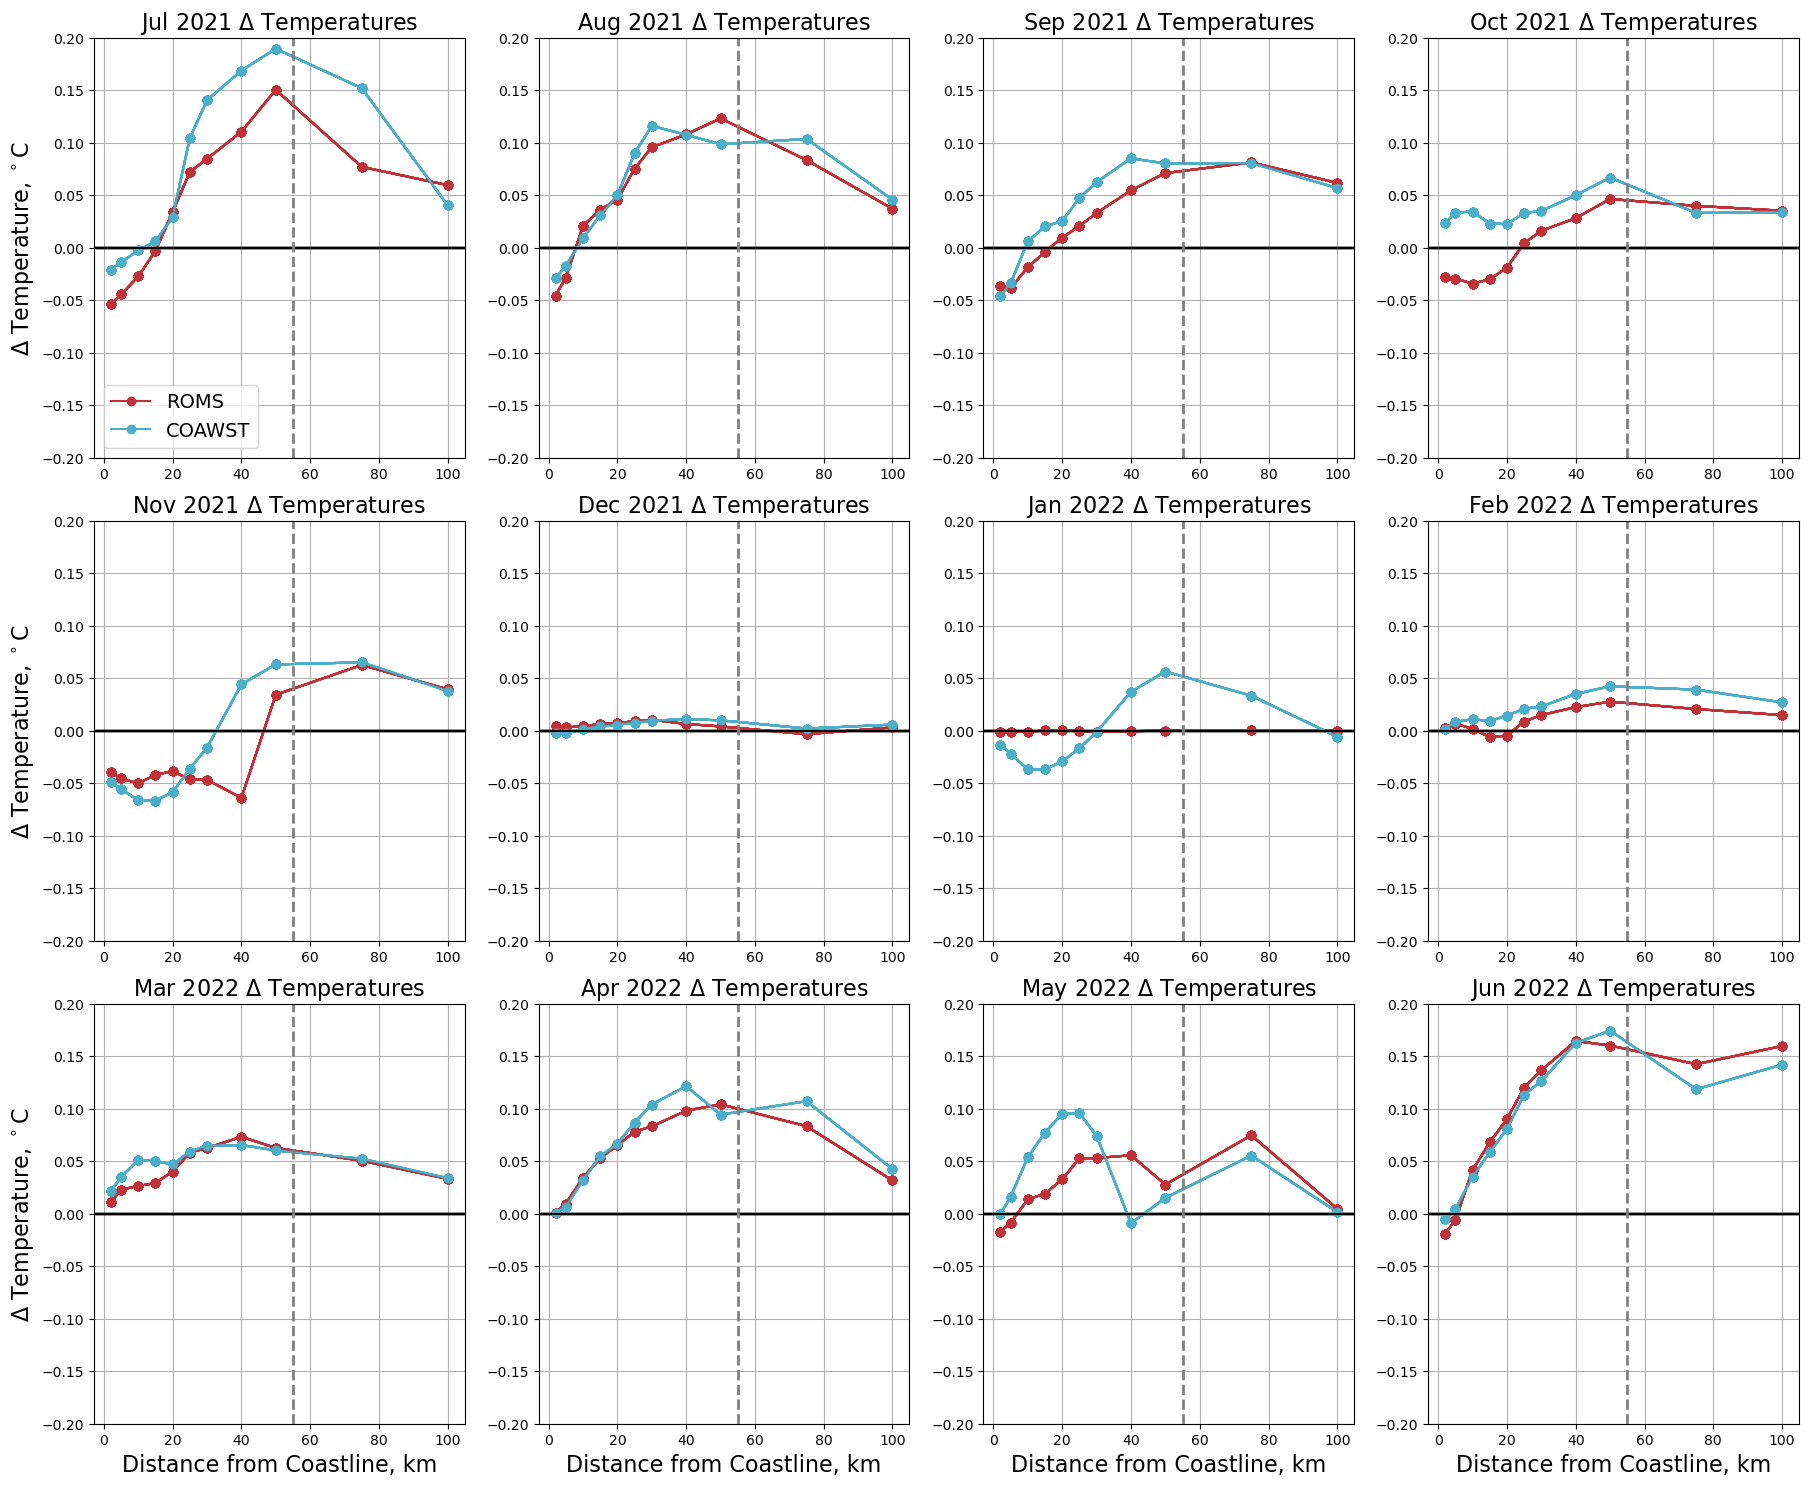

In [16]:
fig = plt.figure(figsize=(22, 18))
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], hspace=0.15)

for i in range(12):
    solo_udiff = solo_upwls[i]
    cpd_udiff = cpd_upwls[i]
    ax = plt.subplot(gs[i])
    for k in range(len(solo_udiff.temp)):
        if k==0:
            ax.plot(udist_km, solo_udiff.temp.mean(dim='ocean_time'), '-o', color=rcolor, label='ROMS')
            ax.plot(udist_km, cpd_udiff.temp.mean(dim='ocean_time'), '-o', color=ccolor, label='COAWST')
        else:
            ax.plot(udist_km, solo_udiff.temp.mean(dim='ocean_time'), '-o', color=rcolor)
            ax.plot(udist_km, cpd_udiff.temp.mean(dim='ocean_time'), '-o', color=ccolor)
        plt.axhline(y=0, color='k', linestyle='-')
    if (i % 4) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)

    if i>7:
        ax.set_xlabel('Distance from Coastline, km', fontsize=16)
    else:
        ax.set_xlabel('')

    if i==0:
        ax.legend(fontsize=14)

    ax.set_title(calendar.month_abbr[mvec[i]] + ' ' + str(yvec[i]) + ' $\Delta$ Temperatures', fontsize=16)
    ax.set_ylim([-0.2, 0.2])
    ax.grid()
    plt.axvline(x=turb_loc, color='grey', linestyle='--', linewidth=2)

fig.savefig('Figure_9.png', format='png', dpi=300, bbox_inches='tight')